# Catboost predictor - One-hot encoded
Implemented version of the catboost model predictor model with one-hot encoding

In [1]:
# import basic libraries
import pandas as pd

# import machine learning libraries
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#import catboost
from catboost import CatBoostRegressor

In [17]:
#import the data
X_train = pd.read_csv("data/generated/example/X_train.csv")
y_train = pd.read_csv("data/generated/example/y_train.csv")
X_test = pd.read_csv("data/generated/example/X_test.csv")
y_test = pd.read_csv("data/generated/example/y_test.csv")
X_test.head()

Unnamed: 0                                 int64
case:concept:name                         object
time:timestamp                            object
case:RequestedAmount                     float64
event_index_in_trace                       int64
Action_Created                             int64
Action_Deleted                             int64
Action_Obtained                            int64
Action_Released                            int64
Action_statechange                         int64
concept:name_A_Accepted                    int64
concept:name_A_Cancelled                   int64
concept:name_A_Complete                    int64
concept:name_A_Concept                     int64
concept:name_A_Create Application          int64
concept:name_A_Denied                      int64
concept:name_A_Incomplete                  int64
concept:name_A_Pending                     int64
concept:name_A_Submitted                   int64
concept:name_A_Validating                  int64
concept:name_O_Accep

### Pre-process the data

In [3]:
#Saving the data into csv adds the numerical indexing
y_test = y_test['remaining_time']
y_train = y_train['remaining_time']

In [4]:
# Drop the unnamed and lifecycle columns column
X_test = X_test.drop(['Unnamed: 0','lifecycle:transition','time:timestamp','org:resource'], axis=1)
X_train = X_train.drop(['Unnamed: 0','lifecycle:transition','time:timestamp','org:resource'], axis=1)

In [5]:
# Separate categorical and numeric features
categorical_features = ['case:concept:name']
numeric_features = X_train.columns.difference(categorical_features)

# Convert categorical features to string
X_train[categorical_features] = X_train[categorical_features].astype(str)
X_test[categorical_features] = X_test[categorical_features].astype(str)

In [6]:
X_train.dtypes

case:concept:name                           object
case:RequestedAmount                       float64
event_index_in_trace                         int64
Action_Created                               int64
Action_Deleted                               int64
Action_Obtained                              int64
Action_Released                              int64
Action_statechange                           int64
concept:name_A_Accepted                      int64
concept:name_A_Cancelled                     int64
concept:name_A_Complete                      int64
concept:name_A_Concept                       int64
concept:name_A_Create Application            int64
concept:name_A_Denied                        int64
concept:name_A_Incomplete                    int64
concept:name_A_Pending                       int64
concept:name_A_Submitted                     int64
concept:name_A_Validating                    int64
concept:name_O_Accepted                      int64
concept:name_O_Cancelled       

### Comparing column length

In [7]:
def compare_columns(df1, df2):
    """
    Compare the column names of two DataFrames and list the columns that are missing in one compared to the other.

    Parameters:
    - df1, df2: DataFrames to be compared.

    Returns:
    - Missing columns in df1 compared to df2 and vice versa.
    """
    missing_in_df1 = set(df2.columns) - set(df1.columns)
    missing_in_df2 = set(df1.columns) - set(df2.columns)

    return {
        'missing_in_df1': list(missing_in_df1),
        'missing_in_df2': list(missing_in_df2)
    }

In [8]:
# Assuming X_train and X_test are your DataFrames
missing_columns = compare_columns(X_train, X_test)

print("Columns missing in X_train compared to X_test:", missing_columns['missing_in_df1'])
print("Columns missing in X_test compared to X_train:", missing_columns['missing_in_df2'])

Columns missing in X_train compared to X_test: []
Columns missing in X_test compared to X_train: ['concept:name_W_Shortened completion ', 'concept:name_W_Personal Loan collection']


In [9]:
#As a quick fix just simply drop the previous columns from X_train
X_train = X_train.drop(['concept:name_W_Shortened completion ', 'concept:name_W_Personal Loan collection'], axis=1)

### Building the model

In [10]:
# Create a CatBoost regressor
model = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.01, loss_function='RMSE')

In [11]:
# Train the model
model.fit(X_train, y_train, cat_features=categorical_features, eval_set=(X_test, y_test), early_stopping_rounds=10, verbose=10)

0:	learn: 13.4484746	test: 11.9328407	best: 11.9328407 (0)	total: 358ms	remaining: 2m 58s
10:	learn: 12.7739336	test: 11.5939497	best: 11.5939497 (10)	total: 2.11s	remaining: 1m 33s
20:	learn: 12.1890270	test: 11.3127361	best: 11.3127361 (20)	total: 3.5s	remaining: 1m 19s
30:	learn: 11.6804574	test: 11.0685916	best: 11.0685916 (30)	total: 4.79s	remaining: 1m 12s
40:	learn: 11.2416867	test: 10.8580217	best: 10.8580217 (40)	total: 6.33s	remaining: 1m 10s
50:	learn: 10.8619820	test: 10.6820727	best: 10.6820727 (50)	total: 7.86s	remaining: 1m 9s
60:	learn: 10.4993989	test: 10.5236273	best: 10.5236273 (60)	total: 9.35s	remaining: 1m 7s
70:	learn: 10.1497947	test: 10.3932865	best: 10.3932865 (70)	total: 10.8s	remaining: 1m 5s
80:	learn: 9.8469230	test: 10.2920322	best: 10.2920322 (80)	total: 12.2s	remaining: 1m 3s
90:	learn: 9.5831560	test: 10.2075623	best: 10.2075623 (90)	total: 13.6s	remaining: 1m 1s
100:	learn: 9.3533261	test: 10.1409080	best: 10.1409080 (100)	total: 15s	remaining: 59.1s


In [12]:
# Make predictions on the test set
y_pred = model.predict(X_test)

### Evaluate the model

In [13]:
# MSE
mean_squared_error(y_test, y_pred)

97.93301564690937

In [14]:
# R2
r2_score(y_test, y_pred)

0.3128214355707044

### Feature importance

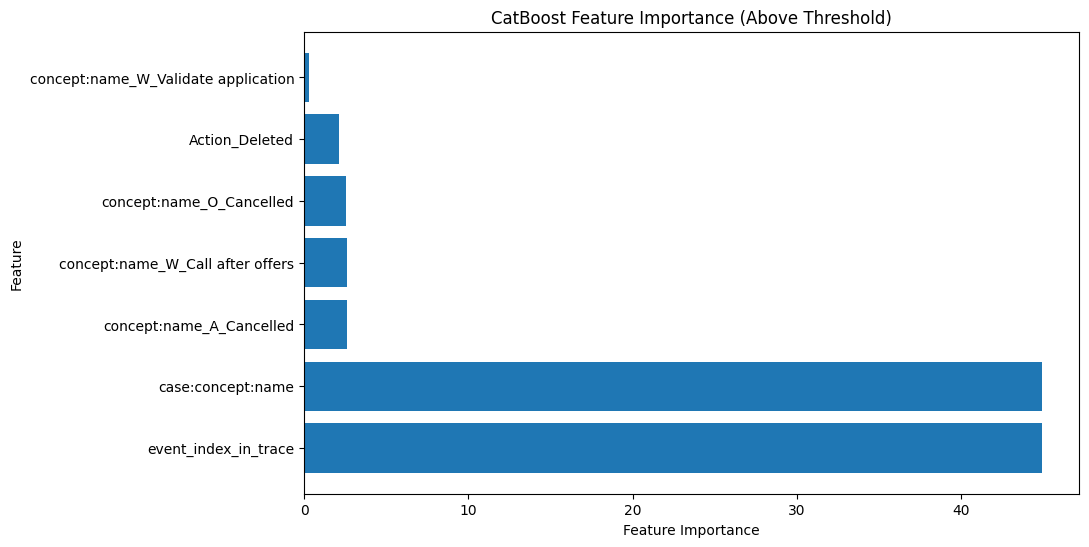

In [15]:
import matplotlib.pyplot as plt

# Assuming 'model' is your trained CatBoostRegressor
feature_importance = model.get_feature_importance()

# Get feature names from the original DataFrame (X_train)
feature_names = X_train.columns

# Create a DataFrame to store feature importance values with their corresponding names
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Set the threshold for visibility
threshold = 0.01  # Adjust this threshold as needed

# Filter features based on the threshold
important_features = feature_importance_df[feature_importance_df['Importance'] >= threshold]

# Sort the DataFrame by importance in descending order
important_features = important_features.sort_values(by='Importance', ascending=False)

# Plot feature importance for only the relevant features
plt.figure(figsize=(10, 6))
plt.barh(important_features['Feature'], important_features['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('CatBoost Feature Importance (Above Threshold)')
plt.show()
